# Iterative testing for Multi-Agent Research Agent

## brief detour: learning langchain/langgraph

In [1]:
import getpass
import os

if "ANTHROPIC_API_KEY" not in os.environ:
    os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")

In [2]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model

model = init_chat_model("claude-sonnet-4-5-20250929", temperature=0)

In [3]:
# define tools
@tool
def add(a: float, b: float) -> float:
    """Adds two numbers together.
    
    args:
        a: First float.
        b: Second float.
    """
    return a + b

@tool
def multiply(a: float, b: float) -> float:
    """Multiplies two numbers together.
    
    args:
        a: First float.
        b: Second float.
    """
    return a * b

@tool
def divide(a: float, b: float) -> float:
    """Divides a by b.
    
    args:
        a: Numerator float.
        b: Denominator float.
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)


## Option 1: using graph API

In [4]:
# Define state
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage, HumanMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int
    
    
def llm_call(state: dict):
    """ LLM decides when/if to use tools """
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ] + state["messages"]
            )
        ],
        "llm_calls": state.get("llm_calls", 0) + 1
    }
    
def tool_node(state: dict):
    """
    Performs the tool call
    """
    
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(
            content=observation,
            tool_call_id=tool_call["id"]
        ))
    return {"messages": result}

# Define end logic
from typing import Literal
from langgraph.graph import StateGraph, START, END

def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """
    Decide to continue loop or stop based on whether the LLM made a tool call
    """
    
    messages = state["messages"]
    last_message = messages[-1]
    
    if last_message.tool_calls:
        return "tool_node"
    return END

# agent_builder = StateGraph(MessagesState)

# agent_builder.add_node("llm_call", llm_call)
# agent_builder.add_node("tool_node", tool_node)

# agent_builder.add_edge(START, "llm_call")
# agent_builder.add_conditional_edges(
#     "llm_call",
#     should_continue,
#     ["tool_node", END]
# )

# agent_builder.add_edge("tool_node", "llm_call")

# agent = agent_builder.compile()

# from IPython.display import Image, display
# display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# messages = [HumanMessage(content="Add 3 and 4")]
# messages = agent.invoke({ "messages": messages })
# for m in messages["messages"]:
#     m.pretty_print()

## Option 2: using functional API

In [5]:
from langchain_core.messages import BaseMessage, ToolCall
from langgraph.func import entrypoint, task
from langgraph.graph import add_messages

@task
def call_llm(messages: list[BaseMessage]):
    return model_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs"
            )
        ] + messages
    )
    
@task
def call_tool(tool_call: ToolCall):
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)

@entrypoint()
def agent(messages: list[BaseMessage]):
    model_response = call_llm(messages).result()
    
    while True:
        if not model_response.tool_calls:
            break
        
        tool_result_futures = [
            call_tool(tool_call) for tool_call in model_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        
        messages = add_messages(messages, [model_response, *tool_results])
        model_response = call_llm(messages).result()
        
    messages = add_messages(messages, model_response)
    return messages

# messages = [HumanMessage(content="Add 3 and 4")]
# chunks = []
# for chunk in agent.stream(messages, stream_mode="updates"):
#     print(chunk)
#     print("\n")
#     chunks.append(chunk)

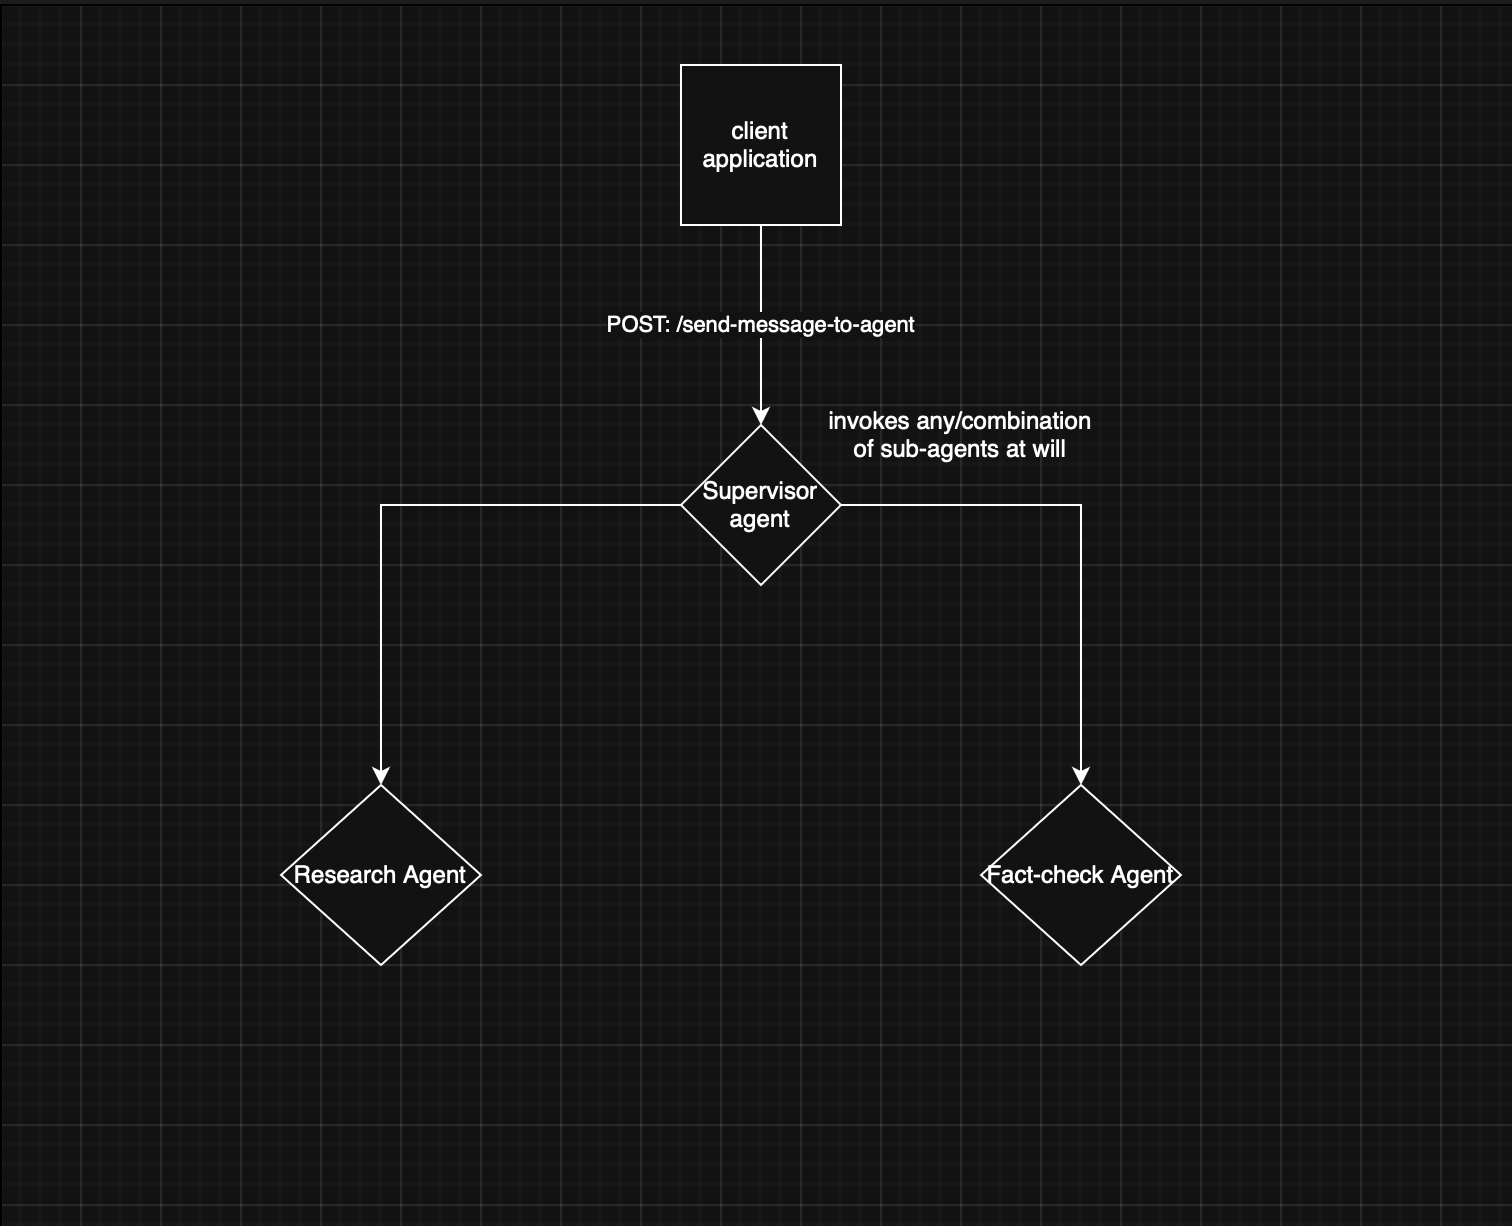

In [6]:
from agents.supervisor import SupervisorAgent

messages = [HumanMessage(content="Perform research on Napoleon")]

supervisor = SupervisorAgent()

for chunk in supervisor.agent_task.stream(messages, stream_mode="updates"):
    print(chunk)

{'call_llm': AIMessage(content=[{'id': 'toolu_01EFBCeDtUdqy3saZunbfRAk', 'input': {'message': 'Research Napoleon Bonaparte - provide comprehensive information about his life, military campaigns, rise to power, reign as Emperor of France, major accomplishments, the Napoleonic Wars, his exile, and historical legacy.'}, 'name': 'invoke_research', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RRAV8KPMZ3ktoY2MRreC67', 'model': 'claude-sonnet-4-5-20250929', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 815, 'output_tokens': 92, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-sonnet-4-5-20250929', 'model_provider': 'anthropic'}, id='lc_run--019b85ff-27a2-78f0-89c8-3c4189be8eb9-0', tool_calls=[{'name': 'invoke_research', 'args': {'message': 'Research Napoleon Bo

In [7]:
chunk['agent']

[HumanMessage(content='Perform research on Napoleon', additional_kwargs={}, response_metadata={}, id='892ac9c1-f289-425b-b937-dff1cd27c1b9'),
 AIMessage(content=[{'id': 'toolu_01EFBCeDtUdqy3saZunbfRAk', 'input': {'message': 'Research Napoleon Bonaparte - provide comprehensive information about his life, military campaigns, rise to power, reign as Emperor of France, major accomplishments, the Napoleonic Wars, his exile, and historical legacy.'}, 'name': 'invoke_research', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RRAV8KPMZ3ktoY2MRreC67', 'model': 'claude-sonnet-4-5-20250929', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 815, 'output_tokens': 92, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-sonnet-4-5-20250929', 'model_provider': 'anthropic'}, id='

In [ ]:
import os
from serpapi import GoogleSearch

GoogleSearch.SERP_API_KEY = os.environ['SERP_API_KEY']
query = GoogleSearch({
    "q": "news on AI agents"
})

query.get_json()

In [8]:
chunk['agent'][1].content

[{'id': 'toolu_01EFBCeDtUdqy3saZunbfRAk',
  'input': {'message': 'Research Napoleon Bonaparte - provide comprehensive information about his life, military campaigns, rise to power, reign as Emperor of France, major accomplishments, the Napoleonic Wars, his exile, and historical legacy.'},
  'name': 'invoke_research',
  'type': 'tool_use'}]

In [9]:
chunk['agent'][2].content

'[AIMessage(content=\'Research Napoleon Bonaparte - provide comprehensive information about his life, military campaigns, rise to power, reign as Emperor of France, major accomplishments, the Napoleonic Wars, his exile, and historical legacy.\', additional_kwargs={}, response_metadata={}, id=\'13163663-5835-4ac8-aba4-b56b279b06fa\', tool_calls=[], invalid_tool_calls=[]), AIMessage(content=[{\'text\': "\\n\\nI\'ll search for comprehensive information about Napoleon Bonaparte across multiple aspects of his life and legacy.", \'type\': \'text\'}, {\'id\': \'toolu_01UZaiZKg83txdYFizEKCaCm\', \'input\': {\'query\': \'Napoleon Bonaparte biography early life rise to power\', \'include_domains\': [\'britannica.com\', \'history.com\', \'wikipedia.org\'], \'max_results\': 10}, \'name\': \'invoke_websearch\', \'type\': \'tool_use\'}, {\'id\': \'toolu_015cCjJjnBxJnvoAn7wHhjGE\', \'input\': {\'query\': \'Napoleon military campaigns battles victories strategies\', \'include_domains\': [\'britannica.